## Initialize environment

In [6]:
import sys
import shutil
import os
import gc
import tqdm
import torch
import random
import pandas as pd
import numpy as np
import anndata as ad
import argparse
import glob
import torchvision
import scprep as scp
import warnings
import torch.nn as nn
import json
import seaborn as sns
import scanpy as sc
import squidpy as sq
import hdf5plugin
import torchstain
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.optim as optim
import scanpy as sc
import numpy as np


# Add relative path
sys.path.append("../")
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch_geometric import utils
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from torchvision import transforms
from squidpy.im import ImageContainer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from scipy.spatial import distance_matrix, minkowski_distance, distance
from typing import Union, Dict, Optional, Tuple, BinaryIO
from pathlib import Path, PurePath
from matplotlib.image import imread
from collections import defaultdict as dfd
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
from Models.DeepPT.deeppt import *
from Models.BLEEP.bleep import *
from Dataloader.Dataset import *

Image.MAX_IMAGE_PIXELS = None
warnings.filterwarnings("ignore")


In [7]:
colornorm = "raw"    # "reinhard", "raw"
dataset_name = "Blake_visium" 
model_name = "deeppt"      # "hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"
gene_list = "func"
exp_norm = "lognorm"
hpc = "vmgpu" 
tmp_path = f"../Dataset/Blake_skin_visium"

if hpc =="wiener":
    abs_path = "/afm03/Q2/Q2051"
elif hpc == "vmgpu":
    abs_path = "/afm01/UQ/Q2051"
elif hpc == "bunya":
    abs_path = "/QRISdata/Q2051"

print("Dataset path:", abs_path)
print("Start training!")
print("Hyperparameters are as follows:")
print("Color normalization method:", colornorm)
print("Dataset_name:", dataset_name)
print("Model_name:", model_name)
print("gene_list:", gene_list)
print("exp_norm:", exp_norm)
print("cluster:", hpc)

if hpc == "wiener":
    abs_path = "/afm03/Q2/Q2051/DeepHis2Exp/Models/Benchmarking_main"
    model_weight_path = "/afm03/Q2/Q2051/DeepHis2Exp/Model_Weights"
   #  model_weight_path = "/scratch/imb/uqyjia11/Yuanhao/DeepHis2Exp/Model_Weights"
    res_path = "/afm03/Q2/Q2051/DeepHis2Exp/Results"
    data_path = "/afm03/Q2/Q2051/DeepHis2Exp/Dataset"
elif hpc == "vmgpu":
    # abs_path = "/afm01/UQ/Q2051/DeepHis2Exp/Implementation"
    model_weight_path = "/afm01/UQ/Q2051/DeepHis2Exp/Model_Weights"
    res_path = "/afm01/UQ/Q2051/DeepHis2Exp/Results"
    data_path = "/afm01/UQ/Q2051/DeepHis2Exp/Dataset"

# Color normalization
# target = cv2.cvtColor(cv2.imread(f"{abs_path}/DeepHis2Exp/Dataset/Reference_Normalization/ref_HE.png"), cv2.COLOR_BGR2RGB)
def color_normalization(img, target=None, method="macenko"):
    """
    img: numpy array, RGB image
    method: str, "raw", "macenko" or "reinhard"
    target: numpy array, RGB image
    """

    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Lambda(lambda x: x*255)
    ])
    if method == "macenko":
        Normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img, Macenko_H, Macenko_E = Normalizer.normalize(I=T(img), stains=True)
    elif method == "reinhard":
        Normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img = Normalizer.normalize(I=T(img))
    elif method == "raw":
        img = img
    return img

def standard_ST_preprocessing(adata):
    # standard Scanpy clustering and umap workflow
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    return adata

def load_img_adata(adata_path, name):
    # Open the TIFF image using PIL
    image = Image.open(f"{adata_path}/{name}.tif")

    # Convert the PIL image to a numpy array
    img = np.array(image)

    # Load the adata
    adata = sc.read_h5ad(f"{adata_path}/{name}.h5ad")
    gc.collect()
    return adata, img

def pad_image(img, target_shape=(224, 224)):
    """
    Pad the input image to match the target shape.
    
    Args:
    - img: Input image (numpy array).
    - target_shape: Desired shape (height, width).
    
    Returns:
    - Padded image.
    """
    h, w = img.shape[:2]
    pad_height = max(0, target_shape[0] - h)
    pad_width = max(0, target_shape[1] - w)
    
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left
    
    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_img

def crop_img(adata, name, img, adata_path, r=112):
    # crop patches
    n_patches = len(adata)
    patches = np.zeros((n_patches,2*r,2*r,3))
    for i in tqdm.tqdm(range(n_patches)):
        y, x = adata.obsm["spatial"].astype(int)[i]
        patches[i] = pad_image(img[x-r:x+r, y-r:y+r, :].astype(np.uint8))
        gc.collect()
    np.save(f"{adata_path}/{name}__patches{r}.npy", patches)
    gc.collect()
    return patches

# Image feature extraction
def FM_extract(name, patches, adata_path, model, image_processor):
    model.eval()
    model.cuda()
    patches_tensor = torch.tensor(patches, dtype=torch.float32).permute(0, 3, 1, 2)
    patch_embs = []
    for i in tqdm.tqdm(range(len(patches_tensor))):
        input = image_processor(patches_tensor[i], return_tensors="pt")
        input["pixel_values"] = input["pixel_values"].cuda()
        patch_embs.append(model(**input)[1].detach().cpu())
        gc.collect()
    patch_embs = torch.squeeze(torch.stack(patch_embs))
    torch.cuda.empty_cache()
    torch.save(patch_embs, f"{adata_path}/{name}__phikon_emb.pt")
    # torch.load(f"{adata_path}/{names[0]}__phikon_emb.pt").shape
    return patch_embs

def gene_plot(target_gene, sample, expression_values, pcc, 
              predicted, image, spatial_coords,):
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot the gene expression data
    plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=expression_values, cmap='viridis', s=12, alpha=0.5)
    plt.colorbar(label='Gene Expression')
    plt.xlabel('X')
    plt.ylabel('Y')
    if predicted:
        plt.title(f'Predicted gene expression: {target_gene}\nPearson correlation coefficient: {pcc.item():.2f}')
    else:
        plt.title(f'Observed gene expression: {target_gene}')
    plt.axis('off')
    if predicted:
        plt.savefig(f"pred_{sample}_{target_gene}.pdf")
    else:
        plt.savefig(f"obs_{sample}_{target_gene}.pdf")
    plt.show()
    gc.collect()


Dataset path: /afm01/UQ/Q2051
Start training!
Hyperparameters are as follows:
Color normalization method: raw
Dataset_name: Blake_visium
Model_name: deeppt
gene_list: func
exp_norm: lognorm
cluster: vmgpu


In [8]:
# list all sample name here
names = [
 'VLP111_D',
 'VLP97_A',
 'VLP108_A',
 'VLP98_D',
 'VLP97_D',
 'VLP108_D',
 'VLP98_A',
 'VLP111_A']
names

['VLP111_D',
 'VLP97_A',
 'VLP108_A',
 'VLP98_D',
 'VLP97_D',
 'VLP108_D',
 'VLP98_A',
 'VLP111_A']

## Data cleanup

In [5]:
# Select the target genes
tmp = sc.read_visium(f'{abs_path}/DeepHis2Exp/Dataset/Blake_skin/VLP108_A/outs')
gene_list = tmp.to_df().columns.values
func_genes = np.load("/home/uqyjia11/Downloads/Q2051/DeepHis2Exp/Dataset/Gene_list/Cancer_Immunology.npy")
hvg_genes = np.load("/home/uqyjia11/Downloads/Q2051/DeepHis2Exp/Dataset/Gene_list/Blake_skin_hvg.npy", allow_pickle=True)
hvg_func = list(set(func_genes) & set(gene_list) & set(hvg_genes))
# Save the gene list with highly variable genes within functional genes
np.save(f"{abs_path}/DeepHis2Exp/Dataset/Gene_list/Blake_skin_hvg_func.npy", hvg_func) # Modify the path to your desired path


In [4]:
# Warp up all raw data into adata object
for name in names:
    tmp = sc.read_visium(f"/home/uqyjia11/Downloads/Q2051/DeepHis2Exp/Dataset/Blake_skin/{name}/outs/")
    tmp.var_names_make_unique()
    tmp.obs_names_make_unique()
    # standard_ST_preprocessing(tmp)
    if Path(tmp_path+f"/{name}.h5ad").is_file() is not True:
        print(f"Saving {name} to {tmp_path}")
        tmp.write_h5ad(tmp_path+f"/{name}.h5ad") # Change it to your saved data path
    else:
        print(f"{name} already exists!")


VLP111_D already exists!
VLP97_A already exists!
VLP108_A already exists!
VLP98_D already exists!
VLP97_D already exists!
VLP108_D already exists!
VLP98_A already exists!
VLP111_A already exists!


Number of filltered spot: 49


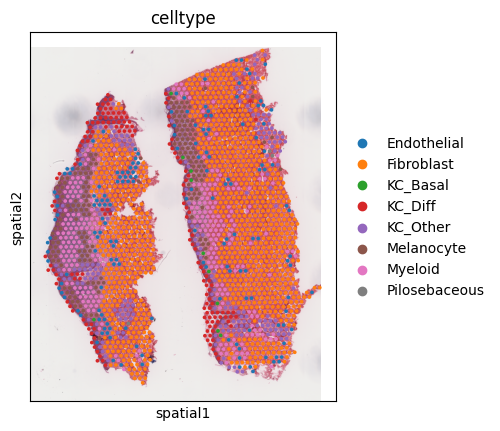

VLP97_A already exists!
Number of filltered spot: 27


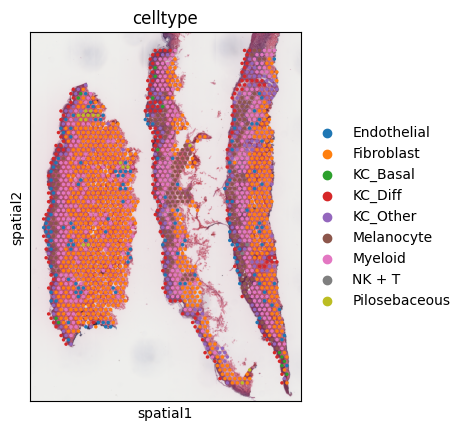

VLP97_D already exists!
Number of filltered spot: 120


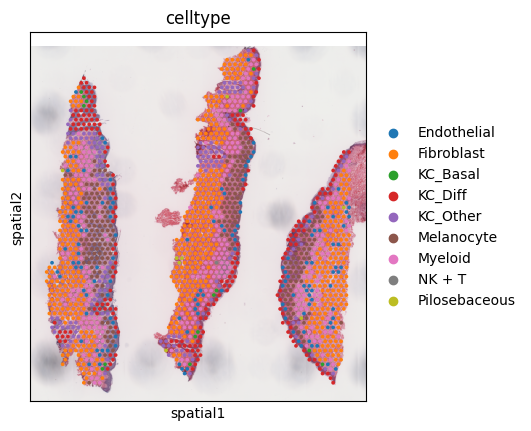

VLP98_A already exists!
Number of filltered spot: 115


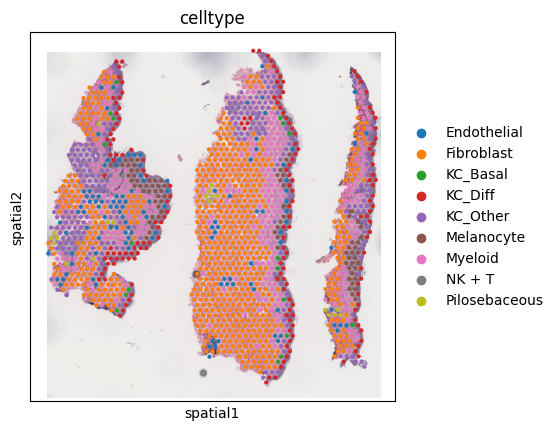

VLP98_D already exists!
Number of filltered spot: 16


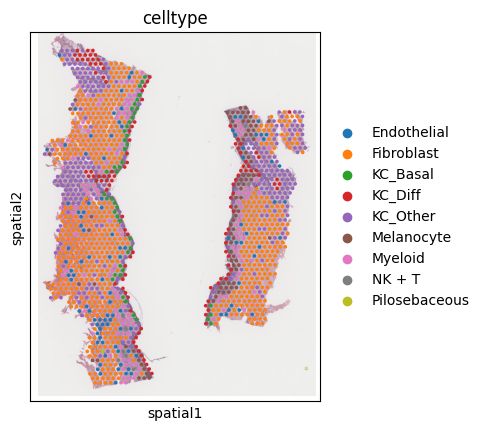

VLP108_A already exists!
Number of filltered spot: 28


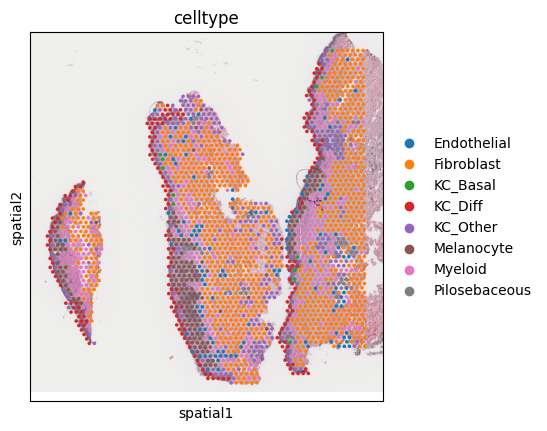

VLP108_D already exists!
Number of filltered spot: 0


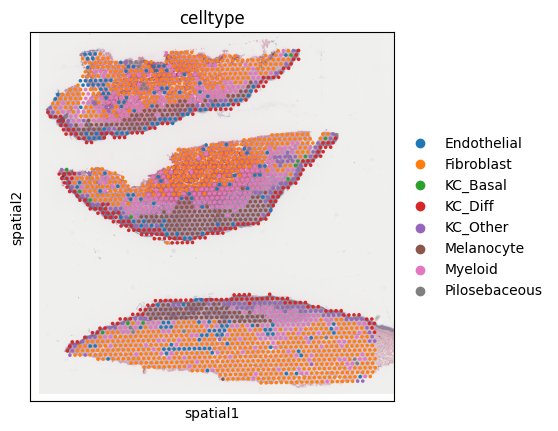

VLP111_A already exists!
Number of filltered spot: 1


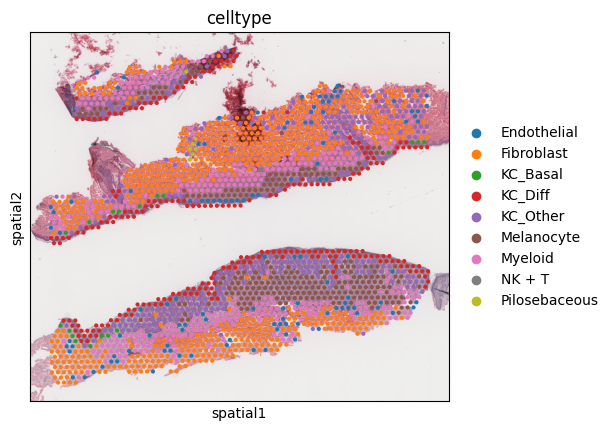

VLP111_D already exists!


In [84]:
# Subset the spots with annotations
lbls = []
adata_lbl = sc.read_h5ad('/home/uqyjia11/Downloads/Q1851/Xiao/Working_project/Skin_Blake/indisct_merge_prep_lt.h5ad')

for name in list(adata_lbl.obs.slide.unique()):
    adata = sc.read_visium(f"/home/uqyjia11/Downloads/Q2051/DeepHis2Exp/Dataset/Blake_skin/{name}/outs/")
    tmp = adata_lbl[adata_lbl.obs.slide == name]
    print("Number of filltered spot:", len(adata)-len(tmp))
    split_names = [name.split('_')[1] for name in list(tmp.obs_names.values)]
    tmp.obs_names = split_names
    adata = adata[tmp.obs.index.values]
    adata.var_names_make_unique()
    adata.obs = pd.concat([adata.obs, tmp.obs], axis=1)
    adata.obsm["spatial"] = adata.obsm["spatial"].astype(int)
    sc.pl.spatial(adata, color='celltype')
    lbls += adata.obs.celltype.unique().astype(str).tolist()
    # adata.write_h5ad(tmp_path+f"/{name}.h5ad") # Change it to your saved data path
    if Path(tmp_path+f"/{name}.h5ad").is_file() is not True:
        print(f"Saving {name} to {tmp_path}")
        adata.write_h5ad(tmp_path+f"/{name}.h5ad") # Change it to your saved data path
    else:
        print(f"{name} already exists!")
lbls = list(set(lbls))


In [83]:
# Check the unique cell types within the dataset
lbls

['KC_Basal',
 'Endothelial',
 'Fibroblast',
 'NK + T',
 'Pilosebaceous',
 'Myeloid',
 'Melanocyte',
 'KC_Diff',
 'KC_Other']

In [35]:
# Crop the patches according to the coordinates
for name in names:
    print(name)
    adata, img = load_img_adata(tmp_path, name)
    tiles = crop_img(adata, name, img, tmp_path)
    adata.obsm['tiles'] = tiles
    adata.write_h5ad(tmp_path+f"/{name}_tiles.h5ad") # Change it to your saved data path


VLP111_D


100%|██████████| 1971/1971 [07:32<00:00,  4.36it/s]


VLP97_A


100%|██████████| 2077/2077 [07:51<00:00,  4.40it/s]


VLP108_A


100%|██████████| 1461/1461 [05:30<00:00,  4.42it/s]


VLP98_D


100%|██████████| 1639/1639 [06:10<00:00,  4.43it/s]


VLP97_D


100%|██████████| 1859/1859 [07:06<00:00,  4.36it/s]


VLP108_D


100%|██████████| 2223/2223 [09:14<00:00,  4.01it/s]


VLP98_A


100%|██████████| 1691/1691 [06:35<00:00,  4.28it/s]


VLP111_A


100%|██████████| 2317/2317 [09:37<00:00,  4.01it/s]


Note: Before we warp up the dataset, plase check the cropped patches first. Sometimes the coordinates in the adata is inconsistent with H&E image. If you find most of tiles were background, or you find the coordinates were out of image scope, you would better address this crucial issue first.

In [ ]:
# Randomly select 9 indices
random_indices = np.random.choice(range(len(adata)), 9, replace=False)

# Plot the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(adata.obsm["tiles"].astype(np.uint8)[random_indices[i]])
    ax.axis('off')

plt.show()
gc.collect()



Extract image features from FMs

If you want to run the code below, you need to activate the environment UNI at the VMGPU.
You can also initialise a new environment following the https://github.com/owkin/HistoSSLscaling.


In [13]:
# import torch
# import numpy as np
# import scanpy as sc
# from transformers import AutoImageProcessor, ViTModel

# # load phikon
# image_processor = AutoImageProcessor.from_pretrained("owkin/phikon")
# model = ViTModel.from_pretrained("owkin/phikon", add_pooling_layer=True)
# tmp_path = f"../Dataset/Blake_skin_visium"

# for name in names:
#     print("Extract the embedding:", name)
#     adata = sc.read_h5ad(f"{tmp_path}/{name}_tiles.h5ad")
#     patches = adata.obsm["tiles"]
#     patch_embs = FM_extract(name, patches, tmp_path, model, image_processor)

Extract the embedding: VLP111_D


100%|██████████| 1971/1971 [05:32<00:00,  5.93it/s]


Extract the embedding: VLP97_A


100%|██████████| 2077/2077 [05:54<00:00,  5.86it/s]


Extract the embedding: VLP108_A


100%|██████████| 1461/1461 [04:11<00:00,  5.80it/s]


Extract the embedding: VLP98_D


100%|██████████| 1639/1639 [04:45<00:00,  5.74it/s]


Extract the embedding: VLP97_D


100%|██████████| 1859/1859 [05:03<00:00,  6.13it/s]


Extract the embedding: VLP108_D


100%|██████████| 2223/2223 [06:00<00:00,  6.17it/s]


Extract the embedding: VLP98_A


100%|██████████| 1691/1691 [04:35<00:00,  6.13it/s]


Extract the embedding: VLP111_A


100%|██████████| 2317/2317 [06:41<00:00,  5.77it/s]


## Warp dataset

In [10]:
# Dataset for pytorch version 
class WarpDataset(Dataset):
    def __init__(self, tr_names, exp_kind="hvg", target_genes=None
                 ):
        """     
        Train/valid/test split:
        tr_names = ['VLP97_A', 'VLP108_A', 'VLP111_D', 'VLP98_D', 'VLP97_D', 'VLP108_D']
        te_names = ['VLP98_A', 'VLP111_A']
        
        Embedding shapes:
        Phikon_emb : num_spots x 768
        UNI_emb : num_spots x 1024
        CONCH_emb : num_spots x 512
        X_scGPT : num_spots x 512
        """
        tmp_path = f"../Dataset/Blake_skin_visium"

        # Concatenate the adata from the trainset
        adata = sc.concat([sc.read_h5ad(f"{tmp_path}/{name}_tiles.h5ad") for name in tqdm.tqdm(tr_names)]).copy()

        # Filter the dataframe, group cell types
        adata.obs = adata.obs.replace('KC_Diff', "KC")
        adata.obs = adata.obs.replace('KC_Other', "KC")
        adata.obs = adata.obs.replace('KC_Basal', "KC")
        self.adata = adata

        # Select the image patches from whole slide image
        self.patches = self.adata.obsm["tiles"]

        # Select the image embedding extracted from foundation models
        self.img_embs = torch.cat([torch.load(f"{tmp_path}/{name}__phikon_emb.pt") for name in tr_names], dim=0)

        # Input the expression data
        if exp_kind == "pca":
            sc.pp.pca(self.adata)
            self.exp = self.adata.obsm["X_pca"]
        elif exp_kind == "raw":
            self.exp = self.adata.to_df().values
        elif exp_kind == "hvg":
            sc.pp.normalize_total(self.adata)
            sc.pp.log1p(self.adata)
            self.exp = self.adata.to_df()[target_genes].values

        # Select the pathology annotation as targets
        self.annotation = self.adata.obs.celltype.values
        self.lbl = torch.tensor(LabelEncoder().fit_transform(self.annotation))
        self.lbl2id = dict(zip(self.annotation, self.lbl))

        # Compute the weights for the cross entropy loss to alleviate class imbalance
        self.class_weights = self.weight_cross_entropy(self.lbl)

        
    def __len__(self):
        return len(self.lbl)
    
    def __getitem__(self, idx):
        imgs = self.patches[idx]
        imgs = torch.tensor(imgs, dtype=torch.float32).permute(2,0,1)
        embs = torch.tensor(self.img_embs[idx], dtype=torch.float32)
        exp = torch.tensor(self.exp[idx], dtype=torch.float32)
        lbl = self.lbl[idx]
        return imgs, embs, exp, lbl
    
    def weight_cross_entropy(self, lbl):
        # Compute class frequencies
        class_counts = torch.bincount(lbl)
        total_samples = torch.sum(class_counts)
        class_frequencies = class_counts.float() / total_samples

        # Inverse class frequency
        class_weights = 1.0 / class_frequencies

        # Normalize the class weights
        class_weights = class_weights / torch.sum(class_weights)
        return class_weights
    

## Subtyping

In [18]:
# Define a function to calculate weights for balanced classes in a dataset
def make_weights_for_balanced_classes(vec_classes, nclasses):
    # Initialize a count list for each class
    count = [0] * nclasses
    
    # Count the occurrences of each class in the dataset
    for i in range(len(vec_classes)):
        count[vec_classes[i].item()] += 1
    
    # Calculate the weight for each class to balance the dataset
    weight_per_class = [0.] * nclasses 
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N / float(count[i])                                 
    
    # Create a list of weights for each sample in the dataset
    weight_for_sample = [0] * len(vec_classes)   
    for i in range(len(vec_classes)):
        c = vec_classes[i].item()
        weight_for_sample[i] = weight_per_class[c]
    
    return weight_for_sample


In [6]:
# Hyperparameters
exp_kind = "raw"
emb_kind = "Phikon_emb"
num_epochs = 50
T_0 = 5
T_mult = 2
lr = 1e-4
batch_size = 1024
weight_balance = False
model_id = f"{emb_kind}_imgexp"
target_genes = np.load("../Dataset/Gene_list/Blake_skin_hvg_func.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if emb_kind == "Phikon_emb":
    img_dim = 768
elif emb_kind == "UNI_emb":
    img_dim = 1024
elif emb_kind == "CONCH_emb":
    img_dim = 512
elif emb_kind == "X_scGPT":
    img_dim = 512
    

In [26]:
tr_names = ['VLP97_A', 'VLP108_A', 'VLP111_D',  'VLP97_D', 'VLP108_D']
val_names = ['VLP98_D']
te_names = ['VLP98_A', 'VLP111_A']

te_dataset = WarpDataset(te_names, exp_kind="raw", target_genes=target_genes)
val_dataset = WarpDataset(val_names, exp_kind="raw", target_genes=target_genes)
tr_dataset = WarpDataset(tr_names, exp_kind="raw", target_genes=target_genes)

# For an unbalanced dataset, create a weighted sampler
# Calculate weights for each class in the dataset
weights = make_weights_for_balanced_classes(tr_dataset.lbl, len(tr_dataset.lbl.unique()))                                                             
weights = torch.DoubleTensor(weights) 

# Create a WeightedRandomSampler for the DataLoader
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

tr_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
te_loader = DataLoader(te_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


In [27]:
class Integration_subtype(torch.nn.Module):
    def __init__(self, img_dim=768, exp_dim=50,
                       latent_dim=256, num_classes=5,
                       ):
        super(Integration_subtype, self).__init__()

        self.img_proj = torch.nn.Linear(img_dim, latent_dim)

        self.exp_proj = torch.nn.Linear(exp_dim, latent_dim)
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(latent_dim*2, num_classes),
            torch.nn.Softmax(dim=-1)
        )
        torch.nn.init.xavier_uniform(self.img_proj.weight)
        torch.nn.init.xavier_uniform(self.exp_proj.weight)
        torch.nn.init.xavier_uniform(self.classifier[0].weight)
        
    
    def encode(self, img_emb, exp_emb):
        x1 = self.img_proj(img_emb)
        x1 = nn.ReLU()(x1)
        x1 = nn.Dropout(0.2)(x1)
        x2 = self.exp_proj(exp_emb)
        x2 = nn.ReLU()(x2)
        x2 = nn.Dropout(0.2)(x2)
        x3 = torch.cat([x1, x2], dim=-1)
        return x3

    def forward(self, img_emb, exp_emb):
        z = self.encode(img_emb, exp_emb)
        subtype = self.classifier(z)
        return subtype
    
    def loss_fn(self, subtype, lbl):
        # Classification loss
        loss = torch.nn.CrossEntropyLoss(reduction='sum')(subtype, lbl)
        return loss
    

In [28]:
# Initialize the model
model = Integration_subtype(exp_dim=te_dataset.exp.shape[1], num_classes=len(tr_dataset.lbl.unique()))
model.to(device)

# Define loss function (CrossEntropyLoss) and optimizer
if weight_balance:
    CE_weight = tr_dataset.class_weights.to(device)
else:
    CE_weight = torch.ones_like(tr_dataset.class_weights).to(device)
optimizer = optim.AdamW(model.parameters(), lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0, T_mult)


In [35]:
# Train the model
best_validation_loss = float('inf')
tr_loss_epoch = []
tr_accuracy_epoch = []
val_loss_epoch = []
val_accuracy_epoch = []

for epoch in range(num_epochs):
    # Training loop
    model.train()  # Set the model to training mode
    tr_loss = []
    iters = len(tr_loader)
    correct = 0
    for i, data in enumerate(tr_loader, 0):
        _, img_embs, exp, labels = data
        img_embs, exp, labels = img_embs.to(device), exp.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        subtype = model(img_embs, exp)  # Forward pass
        pred_lbls = torch.argmax(subtype, dim=-1)
        loss = model.loss_fn(subtype, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        scheduler.step(epoch + i / iters) # Update the learning rate
        tr_loss.append(loss.cpu().detach().numpy())
        correct += (pred_lbls == labels).float().sum()
    tr_acc = correct / len(tr_dataset) # Compute the accuracy
        
    # Validation loop
    model.eval()
    val_loss = []
    for i, data in enumerate(val_loader, 0):
        _, img_embs, exp, labels = data
        img_embs, exp, labels = img_embs.to(device), exp.to(device), labels.to(device)
        subtype = model(img_embs, exp)
        pred_lbls = torch.argmax(subtype, dim=-1)
        loss = model.loss_fn(subtype, labels)  # Compute the loss
        val_loss.append(loss.cpu().detach().numpy())

    # Report loss and accuracy
    print(f"Epoch {epoch+1}, tr_loss: {np.stack(tr_loss).mean()}, val_loss: {np.stack(val_loss).mean()}, tr_accuracy: {tr_acc}")
    tr_loss_epoch.append(np.stack(tr_loss).mean())
    val_loss_epoch.append(np.stack(val_loss).mean())
    tr_accuracy_epoch.append(tr_acc)
    
    # Save model if validation loss has decreased
    if loss < best_validation_loss:
        best_validation_loss = loss
        torch.save(model.state_dict(), f'../../Yuanhao/Spacell2/Model_weights/{model_id}.pth')
        print("Best model saved.")

print('Finished Training')


Epoch 1, tr_loss: 1623.6890869140625, val_loss: 1188.83251953125, tr_accuracy: 0.4814930558204651
Best model saved.
Epoch 2, tr_loss: 1580.837646484375, val_loss: 1188.9771728515625, tr_accuracy: 0.5206964612007141
Epoch 3, tr_loss: 1547.35888671875, val_loss: 1210.6309814453125, tr_accuracy: 0.552497148513794
Epoch 4, tr_loss: 1508.384521484375, val_loss: 1188.9193115234375, tr_accuracy: 0.6025440692901611
Epoch 5, tr_loss: 1507.244873046875, val_loss: 1188.2803955078125, tr_accuracy: 0.6027525663375854
Epoch 6, tr_loss: 1495.2315673828125, val_loss: 1188.3824462890625, tr_accuracy: 0.6158899068832397
Epoch 7, tr_loss: 1442.991943359375, val_loss: 1177.471435546875, tr_accuracy: 0.671358585357666
Epoch 8, tr_loss: 1406.6412353515625, val_loss: 1170.838623046875, tr_accuracy: 0.7067041993141174
Best model saved.
Epoch 9, tr_loss: 1396.093017578125, val_loss: 1166.9290771484375, tr_accuracy: 0.718903124332428
Best model saved.
Epoch 10, tr_loss: 1388.4022216796875, val_loss: 1168.386962

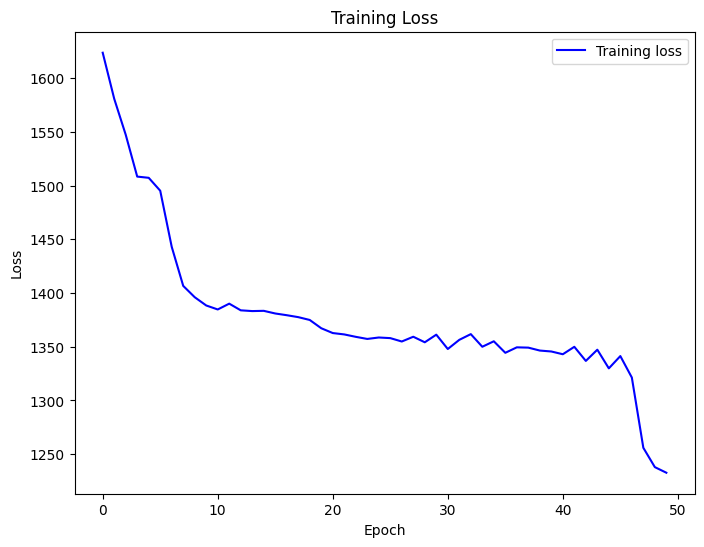

In [36]:
f = plt.figure(figsize=(8, 6))

# Plotting training loss
plt.plot(tr_loss_epoch, color='blue', label='Training loss')

# Adding titles, labels, and legend
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(f"../../Images/{model_id}_loss.png")
plt.show()


In [37]:
def inference(data_loader):
    model.eval()  # Set the model to training mode
    correct = 0
    lbls = []
    pred_lbls = []
    for i, data in enumerate(data_loader, 0):
        _, img_embs, exp, labels = data
        img_embs, exp, labels = img_embs.to(device), exp.to(device), labels.to(device)
        subtype = model(img_embs, exp)
        pred_lbl = torch.argmax(subtype, dim=-1)
        correct += (pred_lbl == labels).float().sum()
        lbls.append(labels.cpu().numpy())
        pred_lbls.append(pred_lbl.cpu().numpy())
    acc = correct / len(tr_dataset) # Compute the accuracy
    print(f"Accuracy for this dataset is : {acc}")
    return pred_lbls, lbls, acc


In [38]:
print("Evaluate train dataset...")
tr_pred_lbls, tr_lbls, tr_acc = inference(tr_loader)

print("Evaluate test dataset...")
te_pred_lbls, te_lbls, te_acc = inference(te_loader)


Evaluate train dataset...
Accuracy for this dataset is : 0.8783234357833862
Evaluate test dataset...
Accuracy for this dataset is : 0.3577311933040619


In [42]:
te_dataset.lbl2id

{'Myeloid': tensor(4),
 'Endothelial': tensor(0),
 'KC': tensor(2),
 'Melanocyte': tensor(3),
 'Fibroblast': tensor(1),
 'Pilosebaceous': tensor(6),
 'NK + T': tensor(5)}